In [330]:
import pandas as pd
import numpy as np
import psycopg2
from analysys_funcs import *
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import optuna
import math

"Сырые" данные о квартирах хранятся в базе данных. Для их получения необходимо установить соединение с ней.

In [63]:
# database connection

conn = psycopg2.connect(host='ep-black-pond-a2ydwdvs.eu-central-1.aws.neon.tech', database='Akademdb', user='Elizar54', password='XUpC1QOnGvA4')
cur = conn.cursor()

Загружаем данные из базы данных.

In [ ]:
# getting data

df = pd.read_sql_query('select * from flats_new', conn)

Осуществляем общую предобработку данных. В предварительную предобработку вошли следующие составляющие:
1. Приведение информации о расстоянии до метро, цене, площади квартиры, количестве туалетов, лифтов, балконах и лоджиях в корректный формат для дальнейшей работы;
2. Удаление колонок, состоящих по большей части из пропущенных значений (warning, trash, barriers), не несущих какой-либо важной информации (id), содержащих большое количество пропущенных значений (decor, year) или одинаковые для всех наблюдений значения (rented).
3. Удаление дупликатов.
4. Заполнение пропусков. Пропуски в колонках с численными значениями были заполнены средним или средним по группе (расстояние до метро в минутах), для категориальных признаков использовалась мода.
5. Удаление наблюдений, в которых отсутствовала информация об общей жилой площади, жилой площади и площади кухни.
6. Удаление наблюдений с некорректным названием района.

In [65]:
# general preproccessing

df['metro'] = df['metro'].apply(metro_distance)
df['price'] = df['price'].apply(price_corr)
df.drop(['id', 'warning', 'trash', 'barriers'], inplace=True, axis=1)
df.drop_duplicates(inplace=True)

for column in ['total_square', 'living_sq', 'kitchen_sq']:
    df[column] = df[column].apply(square_corr)

df['floor'] = df['floor'].apply(floor_corr)
df['ceil_height'] = df['ceil_height'].apply(lambda x: float(x.replace(',', '.').split()[0]) if x != 'None' else np.nan)
df['entrance'] = df['entrance'].apply(lambda x: int(x) if x != 'None' else np.nan)

df['district'] = df['address'].apply(lambda x: x.split()[4] if len(x) >=4 else x)
df = df.replace('None', np.nan)
df.drop('address', inplace=True, axis=1)

df['toilets'].fillna(df['toilets'].mode()[0], inplace=True)
df['warm'].fillna(df['warm'].mode()[0], inplace=True)
df['home_type'].fillna(df['home_type'].mode()[0], inplace=True)
df['ceil_height'] = df['ceil_height'].apply(lambda x: x/10 if x > 10 else x)
df['big_elevs'] = df['elevators'].apply(big_elevators)
df['little_elevs'] = df['elevators'].apply(lit_elevators)
df['single_toilet'] = df['toilets'].apply(toilet_single)
df['connect_toilet'] = df['toilets'].apply(toilet_not_sngl)
df['balcony_only'] = df['balcony'].apply(balcony)
df['lodgia'] = df['balcony'].apply(lodgia)

df = df[df['district'].isin(['Советский', 'Центральный', 'Октябрьский', 'Кировский', \
                              'Ленинский', 'Заельцовский', 'Железнодорожный', 'Первомайский', 'Дзержинский', 'Калининский'])]

In [66]:
df.drop(['decor', 'year', 'rented', 'balcony', 'elevators', 'toilets'], axis=1, inplace=True)


df['ceil_height'].fillna(df['ceil_height'].mode()[0], inplace=True)

df['ceil_height'] = df['ceil_height'].apply(lambda x: x if x != 0 else 2.7)

df['warm'] = df['warm'].apply(lambda x: 'Центральное' if x == 'Нет информации' else x)
df['window_view'].fillna(df['window_view'].mode()[0], inplace=True)
df = df.dropna(subset=['kitchen_sq', 'total_square', 'living_sq'])
cat_features = ['home_type', 'warm', 'district', 'window_view']

df['single_toilet'] = df['single_toilet'].apply(lambda x: x if x != 'None' else 0)
df['connect_toilet'] = df['connect_toilet'].apply(lambda x: x if x != 'None' else 0)

df['metro'].fillna(round(df.groupby('district')['metro'].transform('mean')), inplace=True)

df['entrance'].fillna(round(df['entrance'].mode()[0]), inplace=True)

Так как такие модели как линейная регрессия и случайный лес не могут работать с категориальными признаками, необходимо сформировать датафррейм, в котором категориальные переменные будут преобразованы в dummy переменные. По сути, это то же самое, что и кодирование с помощью One-Hot Encoder. Укажем, что drop_first = True во избежание возникновения мультиколлинеарности.

In [67]:
df_dummy = pd.get_dummies(df, columns=cat_features, dtype = 'float64', drop_first=True)

Проведем EDA (exploratory data analysis). Для начала, построим точечные графики, которые помогут нам пронаблюдать зависимость цены квартир от различных значимых, на мой взгляд, параметров. В качестве таких параметров я выбрал общую площадь, жилую площадь, площадь кухни. Можем видеть, что присутствует сильная положительная корреляция между этими параметрами и ценой на квартиру. Заметны сильные выбросы в данных. Ими нужно будет заняться.

<Axes: xlabel='Площадь кухни', ylabel='Цена квартиры'>

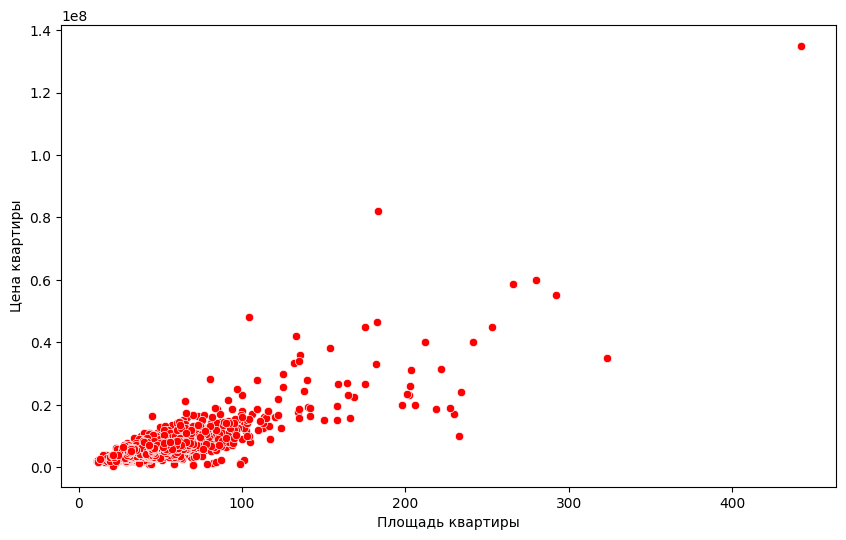

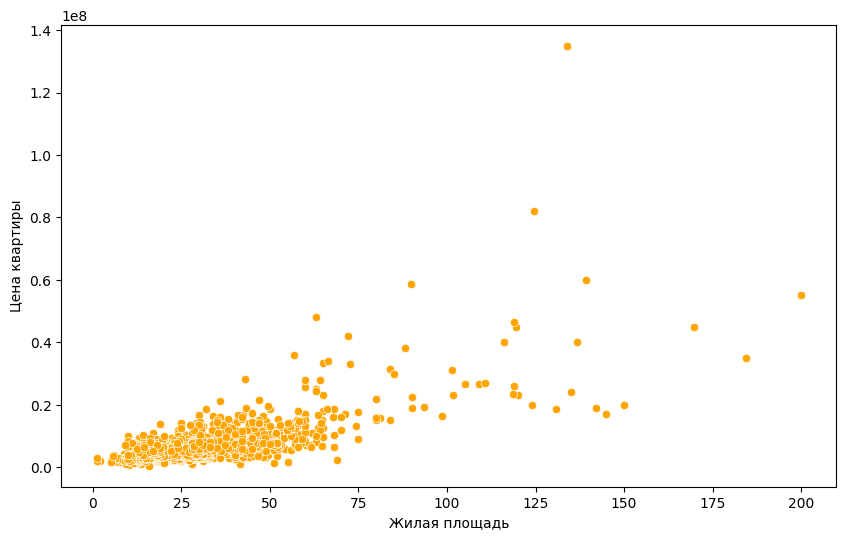

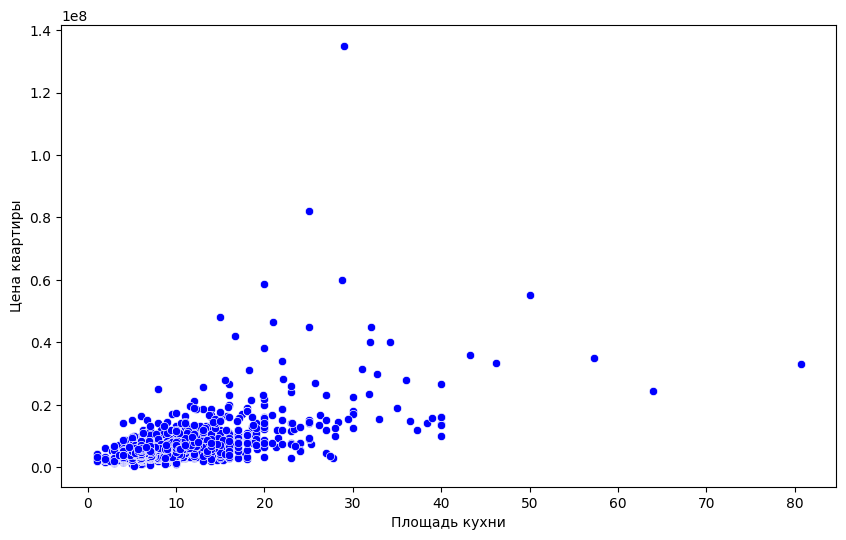

In [68]:
plt.figure(figsize=(10, 6))

plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['total_square'], y=df_dummy['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['living_sq'], y=df_dummy['price'], color='orange')

plt.figure(figsize=(10, 6))
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['kitchen_sq'], y=df_dummy['price'], color='blue')

Теперь взглянем на распределение цен квартир. Для иллюстрации распределения я использовал гистограмму. Количество столбцов определил с помощью правила Стерджесса, добавил ядерную оценку плотности. В результате мы можем видеть тяжелый правый хвост и ассимметрию.

<Axes: xlabel='price', ylabel='Count'>

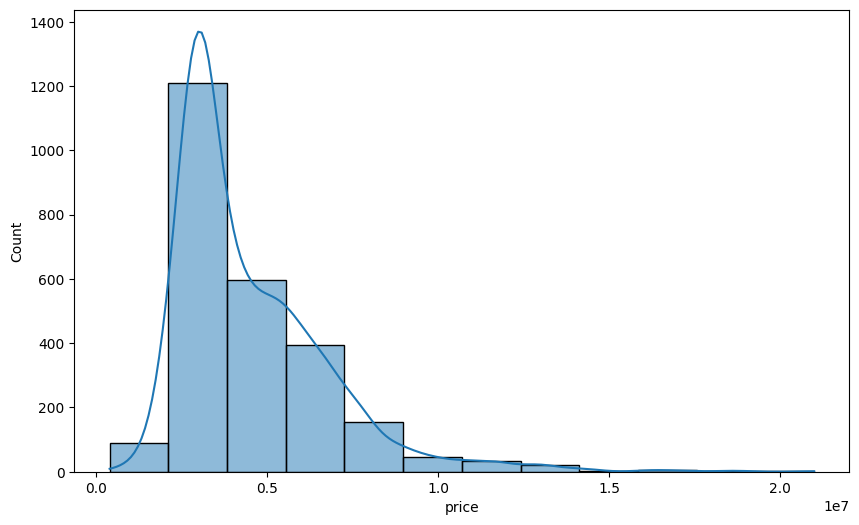

In [344]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=(round(1 + 3.322*math.log(len(df), 10))), kde=True)

Посмотрим на распределение логарифма цен на квартиры. Оно уже больше напоминает нормальное.

<Axes: title={'center': 'Гистограмма логарифмированных цен на квартиры'}, xlabel='Логарифм цены квартиры', ylabel='Количество квартир'>

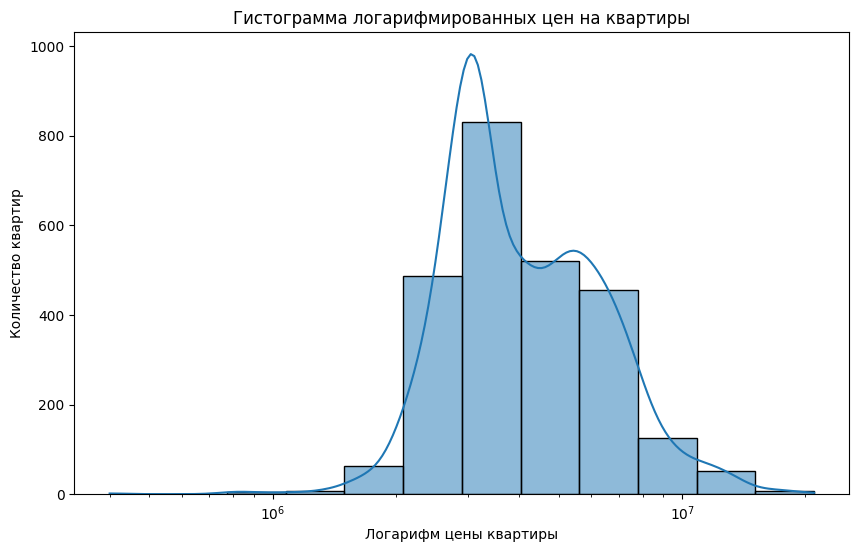

In [345]:
plt.figure(figsize=(10, 6))
plt.xlabel('Логарифм цены квартиры')
plt.ylabel('Количество квартир')
plt.title('Гистограмма логарифмированных цен на квартиры')
sns.histplot(df['price'], bins=(round(1 + 3.322*math.log(len(df), 10))), log_scale=True, kde=True)

<Axes: xlabel='Расстояние до метро (в минутах)', ylabel='Количество квартир'>

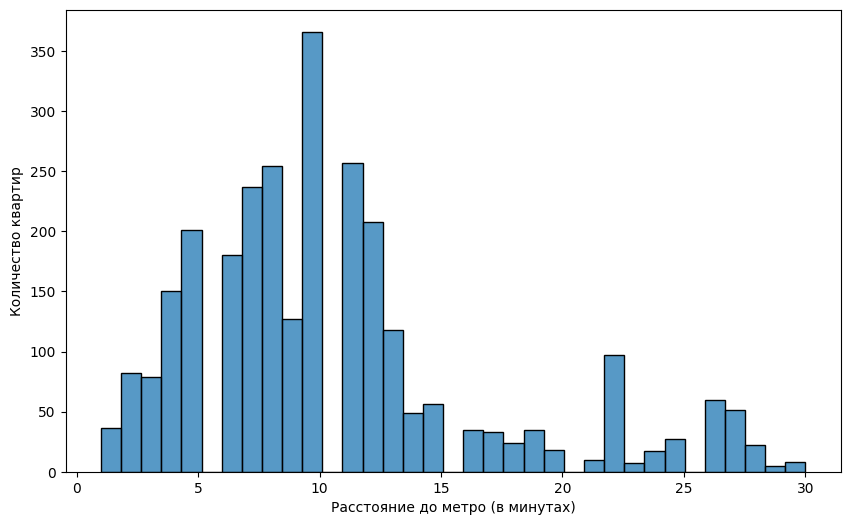

In [75]:
plt.figure(figsize=(10, 6))
plt.xlabel('Расстояние до метро (в минутах)')
plt.ylabel('Количество квартир')
sns.histplot(df['metro'])

<Axes: xlabel='Район', ylabel='Количестов квартир'>

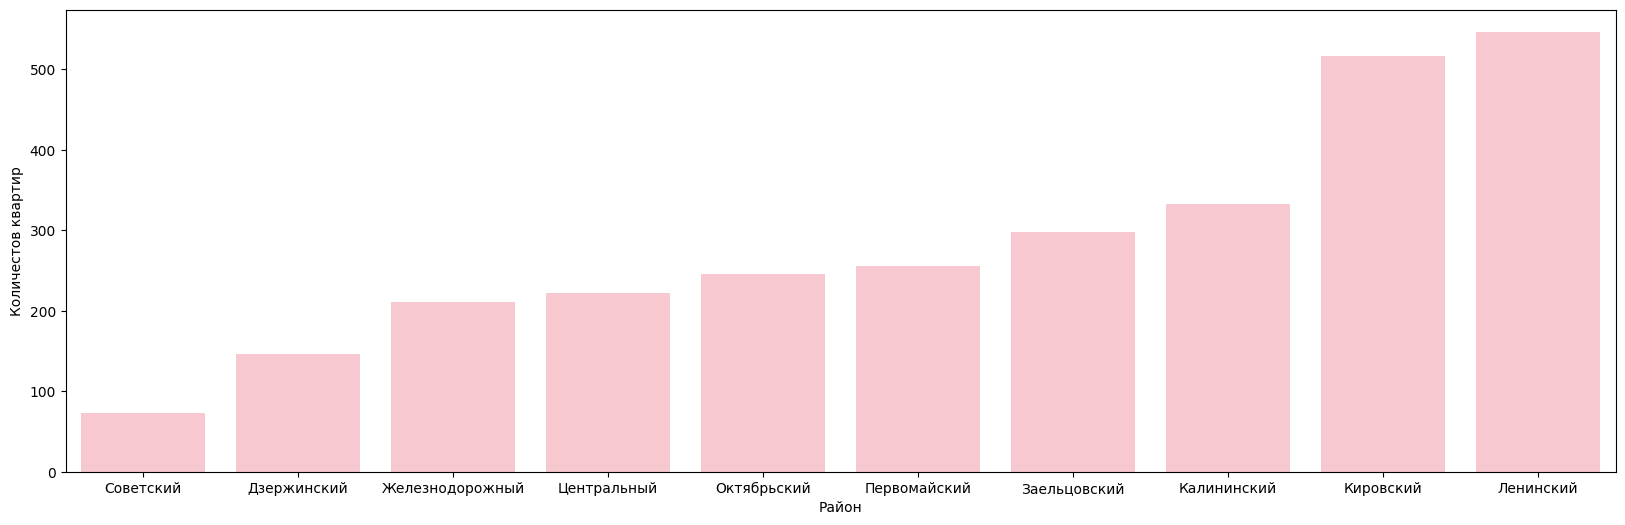

In [79]:
plt.figure(figsize=(20, 6))
plt.ylabel('Количестов квартир')
plt.xlabel('Район')
districts = df['district'].value_counts(ascending=True)
sns.barplot(districts, color='pink')

<Axes: xlabel='Высота потолков', ylabel='Цена квартиры'>

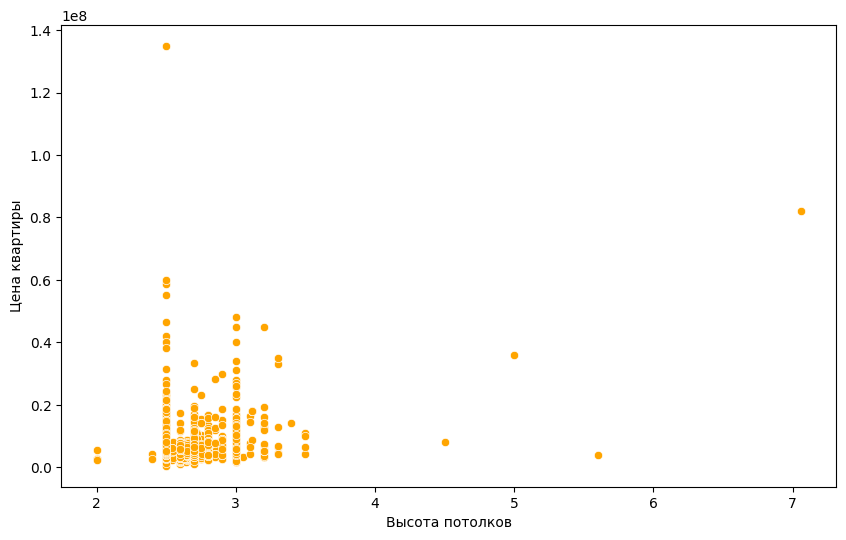

In [80]:
plt.figure(figsize=(10, 6))

plt.xlabel('Высота потолков')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df['ceil_height'], y=df['price'], color='orange')

In [81]:
# outliers (old flats)

for column in['total_square', 'ceil_height', 'kitchen_sq']:
    q1 = df_dummy[column].quantile(0.25)
    q3 = df_dummy[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    df_dummy = df_dummy[df_dummy[column].between(lower_bound, upper_bound)]
    df = df[df[column].between(lower_bound, upper_bound)]
    

<Axes: title={'center': 'Гистограмма общей площади квартир'}, xlabel='Общая площадь квартиры', ylabel='Количество квартир'>

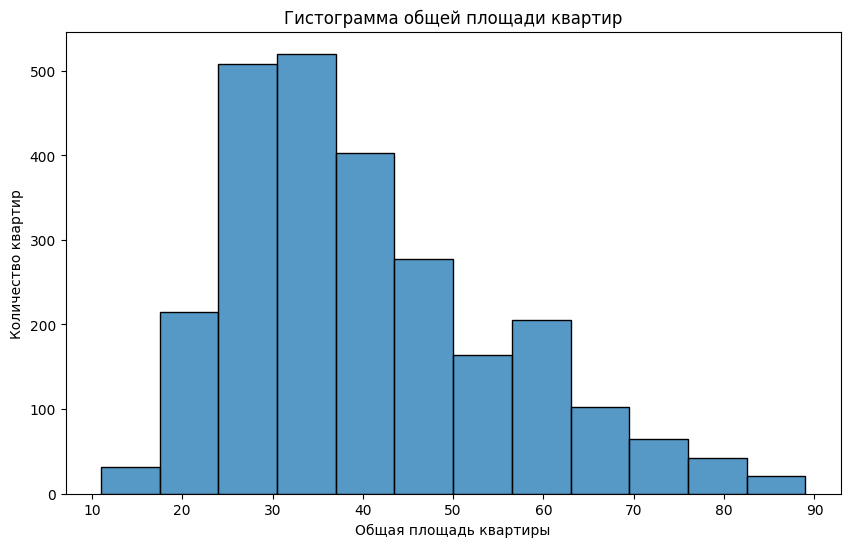

In [336]:
plt.figure(figsize=(10, 6))
plt.title('Гистограмма общей площади квартир')
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Количество квартир')
sns.histplot(df_dummy['total_square'], bins=(round(1 + 3.322*math.log(len(df), 10))))

<Axes: xlabel='Расстояние до метро (в минутах)', ylabel='Цена квартиры'>

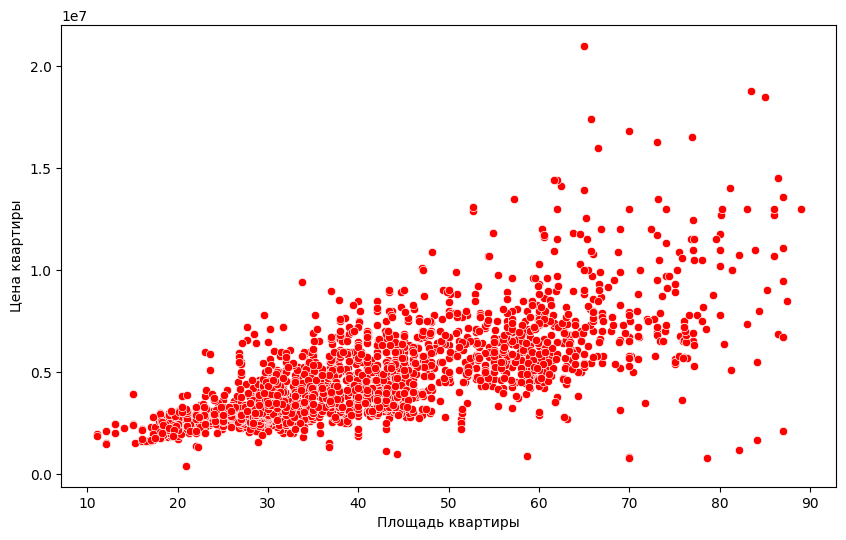

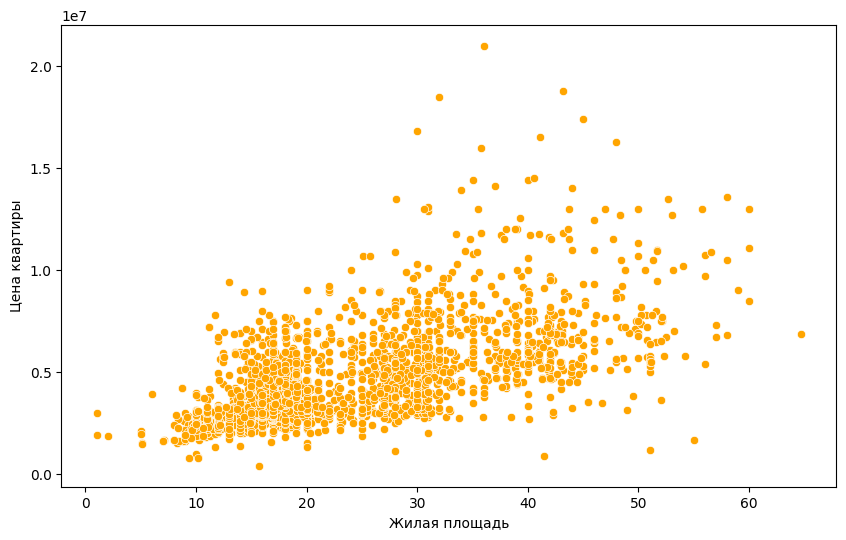

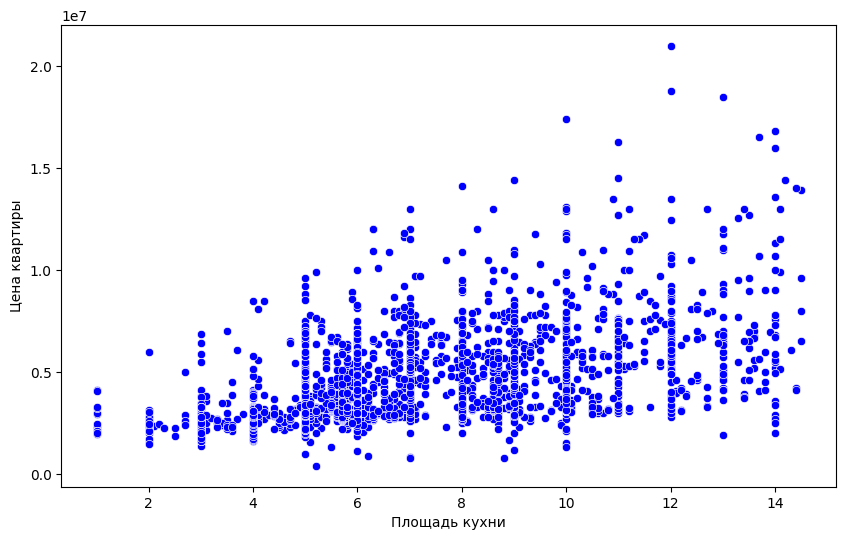

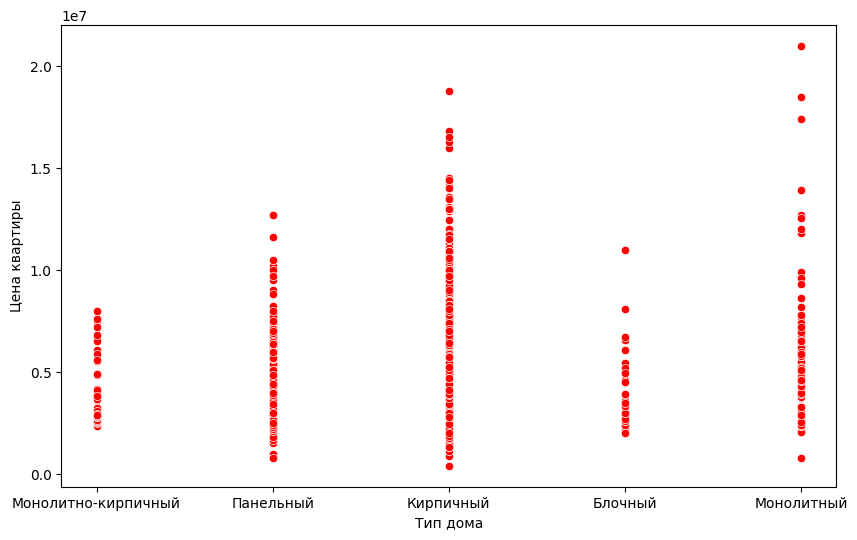

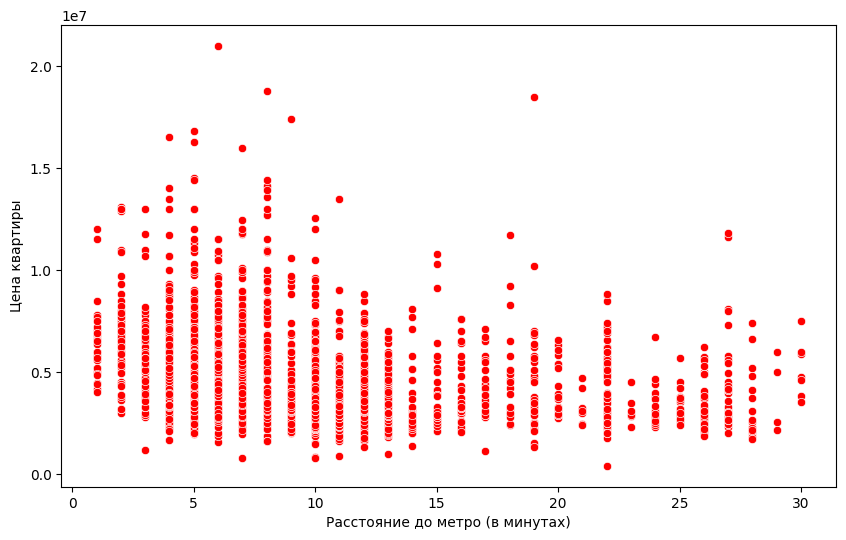

In [85]:
plt.figure(figsize=(10, 6))

plt.xlabel('Площадь квартиры')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['total_square'], y=df_dummy['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Жилая площадь')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['living_sq'], y=df_dummy['price'], color='orange')

plt.figure(figsize=(10, 6))
plt.xlabel('Площадь кухни')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df_dummy['kitchen_sq'], y=df_dummy['price'], color='blue')

plt.figure(figsize=(10, 6))
plt.xlabel('Тип дома')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df['home_type'], y=df['price'], color='red')

plt.figure(figsize=(10, 6))
plt.xlabel('Расстояние до метро (в минутах)')
plt.ylabel('Цена квартиры')
sns.scatterplot(x=df['metro'], y=df['price'], color='red')

In [338]:
# linear regression
train, test = train_test_split(df_dummy, test_size=0.2, random_state=34)

x = train.drop(['price'], axis=1)
y = train['price']

In [339]:
maxpvalue = 1
n = 1
regressors = train.drop('price', axis=1).columns.to_list()

while maxpvalue > 0.05:
    x = train[regressors]
    y = train['price']
    x1 = sm.add_constant(x)
    model = sm.OLS(y, x1.astype(float)).fit()
    pv = model.pvalues.to_list()
    maxpv = max(pv[1:])
    max_index = pv.index(maxpv)
    print('Номер интерации: '+ str(n))
    print('Регрессор с максимальным p-value: '+ str(regressors[max_index-1]) + ' P-value: '+ str(maxpv))
    print('-------------------------------------------------------------')

    if maxpv > 0.05:
        regressors.pop(max_index - 1)
        maxpvalue = maxpv
        n += 1
    else:
        maxpvalue = 0

print('Итоговая модель: ')
y = train['price']
x = train[regressors]
x1 = sm.add_constant(x)
model = sm.OLS(y, x1.astype(float)).fit()
print(model.summary2())

Номер интерации: 1
Регрессор с максимальным p-value: warm_Котел/Квартирное отопление P-value: 0.9993696373440684
-------------------------------------------------------------
Номер интерации: 2
Регрессор с максимальным p-value: warm_Индивидуальный тепловой пункт P-value: 0.94385655048063
-------------------------------------------------------------
Номер интерации: 3
Регрессор с максимальным p-value: entrance P-value: 0.281864528750564
-------------------------------------------------------------
Номер интерации: 4
Регрессор с максимальным p-value: home_type_Монолитный P-value: 0.2287998718678346
-------------------------------------------------------------
Номер интерации: 5
Регрессор с максимальным p-value: district_Дзержинский P-value: 0.06345477565067216
-------------------------------------------------------------
Номер интерации: 6
Регрессор с максимальным p-value: district_Советский P-value: 0.30760564793373163
-------------------------------------------------------------
Номер 

In [340]:
print(model.summary2())

                                 Results: Ordinary least squares
Model:                         OLS                        Adj. R-squared:               0.744     
Dependent Variable:            price                      AIC:                          62850.1274
Date:                          2024-05-04 23:39           BIC:                          63018.7779
No. Observations:              2042                       Log-Likelihood:               -31395.   
Df Model:                      29                         F-statistic:                  205.6     
Df Residuals:                  2012                       Prob (F-statistic):           0.00      
R-squared:                     0.748                      Scale:                        1.3434e+12
--------------------------------------------------------------------------------------------------
                                  Coef.       Std.Err.     t    P>|t|      [0.025        0.975]   
--------------------------------------------

In [341]:
test_1 = test[model.params.index.to_list()[1:]]
test_1 = sm.add_constant(test_1)
pred = model.predict(test_1)

In [342]:
mean_absolute_error(test['price'], pred)

772417.7545927828

In [131]:
# RF

def objective_rf(trial):
    X_train, X_val, y_train, y_val = train_test_split(df_dummy.drop(['price'], axis=1), df_dummy['price'], test_size=0.2)

    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    max_depth = trial.suggest_int('max_depth', 5, 10)

    model = RandomForestRegressor(max_depth=max_depth, max_features='sqrt', min_samples_split=min_samples_split, \
                                   n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    mse = mean_squared_error(y_val, val_preds)

    return mse

In [132]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective_rf, n_trials=100)

[I 2024-05-04 17:13:16,037] A new study created in memory with name: no-name-991d3631-2012-4d79-b010-271e14b15fd0
[I 2024-05-04 17:13:16,150] Trial 0 finished with value: 1845810345538.5464 and parameters: {'n_estimators': 80, 'min_samples_split': 8, 'max_depth': 5}. Best is trial 0 with value: 1845810345538.5464.
[I 2024-05-04 17:13:16,197] Trial 1 finished with value: 1670328332120.8198 and parameters: {'n_estimators': 30, 'min_samples_split': 2, 'max_depth': 5}. Best is trial 1 with value: 1670328332120.8198.
[I 2024-05-04 17:13:16,346] Trial 2 finished with value: 1327727947538.4211 and parameters: {'n_estimators': 75, 'min_samples_split': 7, 'max_depth': 7}. Best is trial 2 with value: 1327727947538.4211.
[I 2024-05-04 17:13:16,413] Trial 3 finished with value: 1797468479112.2756 and parameters: {'n_estimators': 41, 'min_samples_split': 5, 'max_depth': 5}. Best is trial 2 with value: 1327727947538.4211.
[I 2024-05-04 17:13:16,442] Trial 4 finished with value: 1599638173468.7485 an

In [133]:
best_params = study.best_params
best_params

{'n_estimators': 31, 'min_samples_split': 7, 'max_depth': 10}

In [134]:
model_rf = RandomForestRegressor(**best_params, max_features='sqrt', random_state=30)
model_rf.fit(train.drop('price', axis=1), train['price'])
pred_rf = model_rf.predict(test.drop('price', axis=1))
mean_absolute_error(pred_rf, test['price'])

666180.2391375138

In [145]:
cross_val_score(model_rf, df_dummy.drop('price', axis=1), df_dummy['price'], cv=5, scoring='neg_mean_absolute_error')

array([-937856.52207702, -644977.53948453, -591649.63141233,
       -682861.80429589, -868285.147301  ])

In [135]:
df_compare_rf = pd.DataFrame({'real': test['price'], 'predicted': pred_rf})

In [146]:
def objective_gb(trial):
    X_train, X_val, y_train, y_val = train_test_split(df.drop(['price'], axis=1), df_dummy['price'], test_size=0.2)

    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1)
    depth = trial.suggest_int('depth', 5, 10)
    l2_reg = trial.suggest_float('l2_leaf_reg', 0, 20)

    model = CatBoostRegressor(depth=depth, learning_rate=learning_rate, n_estimators=n_estimators, l2_leaf_reg=l2_reg, cat_features=cat_features)
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    mse = mean_squared_error(y_val, val_preds)

    return mse

In [ ]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective_gb, n_trials=100)

In [148]:
best_params = study.best_params
best_params

{'n_estimators': 79,
 'learning_rate': 0.41279377276129803,
 'depth': 10,
 'l2_leaf_reg': 16.244136729179033}

In [149]:
model_gb = CatBoostRegressor(**best_params, random_seed=42)
model_gb.fit(train.drop('price', axis=1), train['price'])

0:	learn: 1880835.7235193	total: 13.1ms	remaining: 1.02s
1:	learn: 1655004.9472712	total: 22.7ms	remaining: 873ms
2:	learn: 1515439.9167639	total: 32.8ms	remaining: 830ms
3:	learn: 1407708.6034538	total: 43.1ms	remaining: 808ms
4:	learn: 1332747.0711874	total: 53.1ms	remaining: 786ms
5:	learn: 1268889.2158376	total: 63.7ms	remaining: 776ms
6:	learn: 1199776.5761889	total: 73.2ms	remaining: 753ms
7:	learn: 1166531.3028748	total: 84.3ms	remaining: 748ms
8:	learn: 1130912.2460804	total: 94.9ms	remaining: 738ms
9:	learn: 1104129.1335906	total: 106ms	remaining: 733ms
10:	learn: 1076842.7832716	total: 117ms	remaining: 722ms
11:	learn: 1051011.5074551	total: 127ms	remaining: 710ms
12:	learn: 1019646.0116392	total: 137ms	remaining: 695ms
13:	learn: 1003520.6724542	total: 147ms	remaining: 685ms
14:	learn: 987658.2259906	total: 158ms	remaining: 673ms
15:	learn: 970542.6493471	total: 168ms	remaining: 661ms
16:	learn: 953166.1327411	total: 178ms	remaining: 650ms
17:	learn: 937418.1931197	total: 18

In [150]:
pred_gb = model_gb.predict(test.drop('price', axis=1))

In [151]:
mean_absolute_error(test['price'], pred_gb)

606268.1935222158

In [152]:
compare_df_gb = pd.DataFrame({'real': test['price'], 'predicted': pred_gb})

In [153]:
cross_val_score(model_gb, df_dummy.drop('price', axis=1), df_dummy['price'], cv=5, scoring='neg_mean_absolute_error')

0:	learn: 1794261.9284586	total: 11.2ms	remaining: 871ms
1:	learn: 1542467.4343662	total: 20.7ms	remaining: 797ms
2:	learn: 1383721.9126282	total: 31.5ms	remaining: 798ms
3:	learn: 1267115.9130824	total: 41.3ms	remaining: 774ms
4:	learn: 1188947.3826760	total: 51.7ms	remaining: 765ms
5:	learn: 1137730.3928699	total: 61.8ms	remaining: 752ms
6:	learn: 1088408.8558027	total: 72.9ms	remaining: 750ms
7:	learn: 1058506.9419564	total: 83.3ms	remaining: 739ms
8:	learn: 1033447.5331946	total: 93ms	remaining: 724ms
9:	learn: 1008687.0354650	total: 104ms	remaining: 716ms
10:	learn: 980749.8972558	total: 114ms	remaining: 706ms
11:	learn: 956311.3580522	total: 117ms	remaining: 656ms
12:	learn: 931526.4439683	total: 128ms	remaining: 650ms
13:	learn: 910518.2058145	total: 138ms	remaining: 643ms
14:	learn: 892399.5082175	total: 150ms	remaining: 638ms
15:	learn: 873997.7984646	total: 159ms	remaining: 627ms
16:	learn: 853403.2353380	total: 170ms	remaining: 620ms
17:	learn: 833816.0025944	total: 181ms	re

array([-852513.9519343 , -494838.11833573, -547819.4261526 ,
       -679634.38115771, -867972.83185868])

Text(0.5, 1.0, 'Feature Importance')

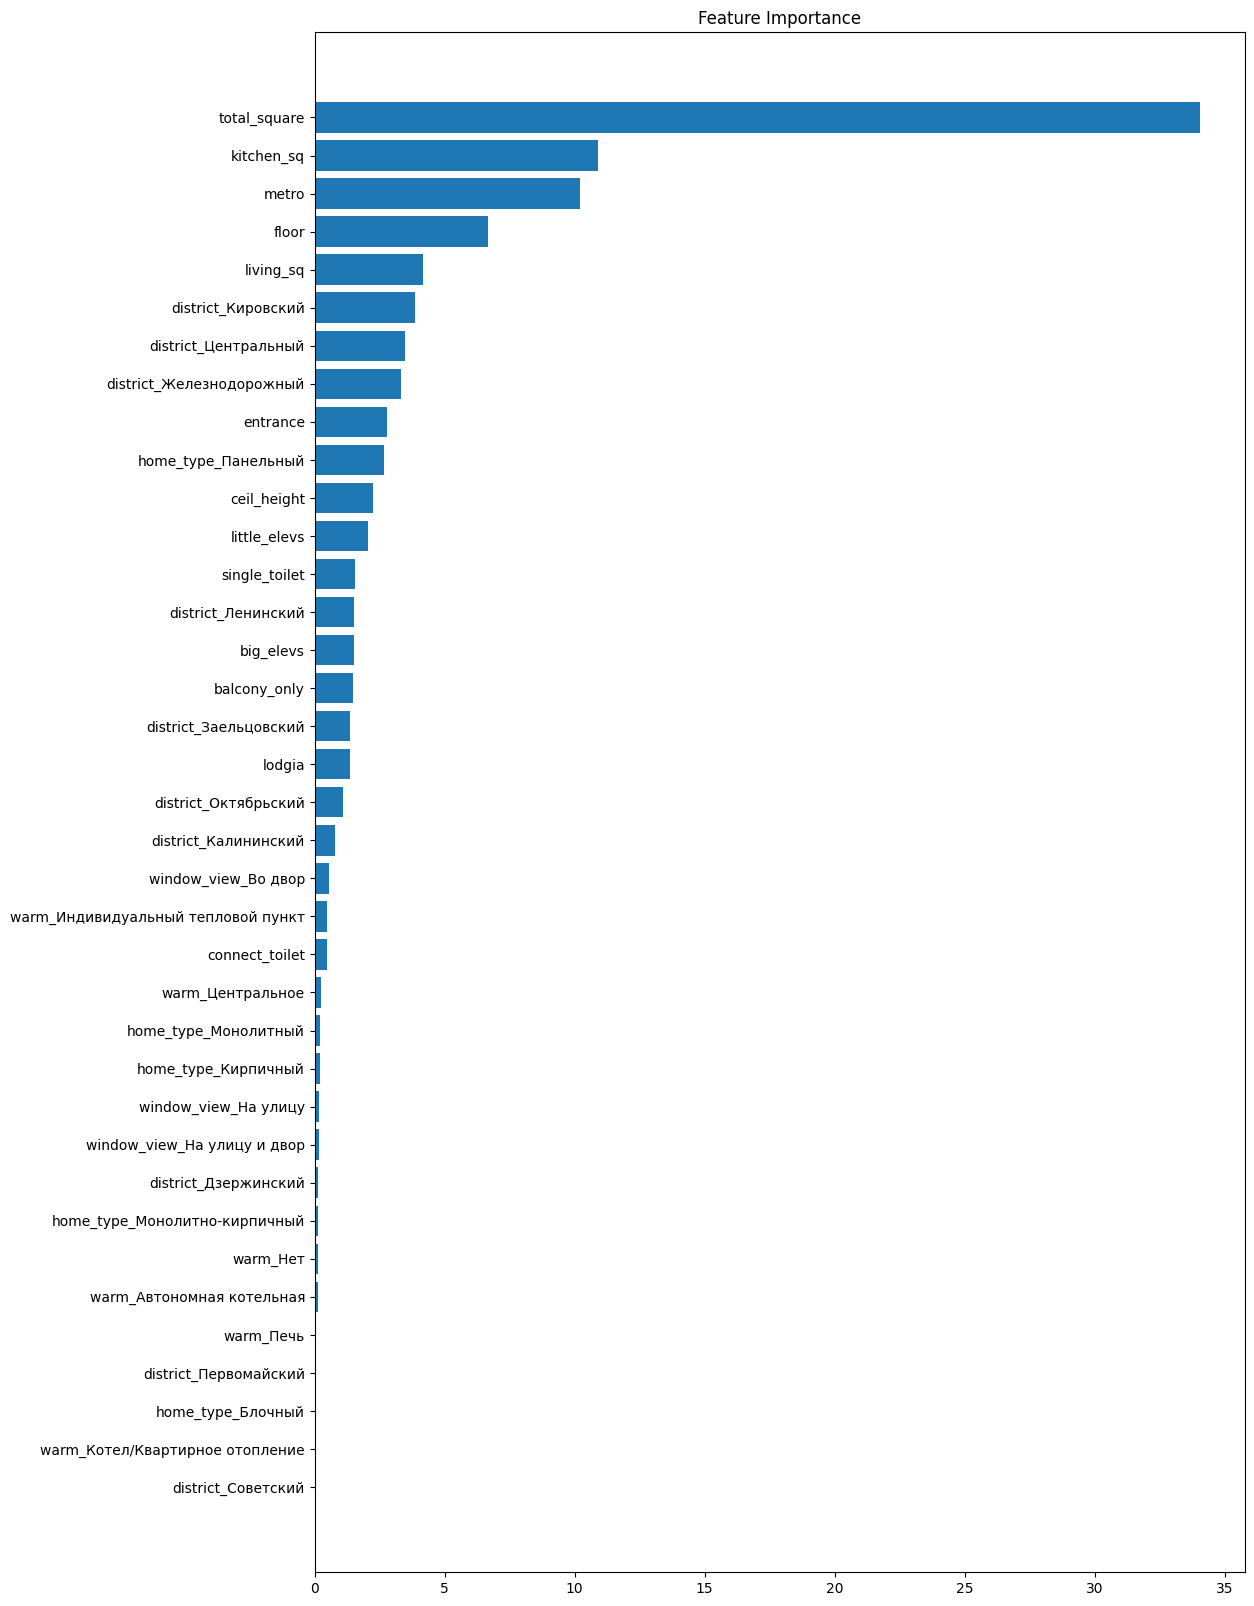

In [191]:
feature_importance = model_gb.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test.drop('price', axis=1).columns)[sorted_idx])
plt.title('Feature Importance')

In [296]:
# evaluating models
df_mae = pd.DataFrame({})
df_mape = pd.DataFrame({})
df_mse = pd.DataFrame({})

groups = [(1000000, 2000000), (2000000, 3000000), (4000000, 5000000), (6000000, 7000000), (7000000, float('inf'))]

print('Случайный лес: ')
result_mae = []
result_mape = []
result_mse = []

for group in groups:
    print(f'{group[0]} рублей - {group[1]} рублей')
    predict = model_rf.predict(test[test['price'].between(group[0], group[1])].drop('price', axis=1))
    result_mae.append(mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict))
    result_mape.append(mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict))
    result_mse.append(mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict))
    print(f'MAE: {mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict) * 100} %')
    print(f'MSE: {mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print()


Случайный лес: 
1000000 рублей - 2000000 рублей
MAE: 833009.2472428344
MAPE: 47.91512307940609 %
MSE: 921215923104.5072

2000000 рублей - 3000000 рублей
MAE: 438116.42646405095
MAPE: 17.101275460289205 %
MSE: 335300689024.4681

4000000 рублей - 5000000 рублей
MAE: 498869.18062102364
MAPE: 10.963160703351488 %
MSE: 410251659451.24054

6000000 рублей - 7000000 рублей
MAE: 670474.3991045981
MAPE: 10.124673123621966 %
MSE: 731821668147.3125

7000000 рублей - inf рублей
MAE: 1787173.8532776237
MAPE: 19.18398715240818 %
MSE: 4562955413459.071



In [297]:
print('Градиентный бустинг: ')

for group in groups:
    print(f'{group[0]} рублей - {group[1]} рублей')
    predict = model_gb.predict(test[test['price'].between(group[0], group[1])].drop('price', axis=1))
    result_mae.append(mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict))
    result_mape.append(mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict))
    result_mse.append(mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict))
    print(f'MAE: {mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict)*100} %')
    print(f'MSE: {mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print()

Градиентный бустинг: 
1000000 рублей - 2000000 рублей
MAE: 555864.7952660244
MAPE: 32.30720013453853 %
MSE: 553676227513.2849

2000000 рублей - 3000000 рублей
MAE: 322310.05631836544
MAPE: 12.4308328316253 %
MSE: 217131952777.045

4000000 рублей - 5000000 рублей
MAE: 461288.574749899
MAPE: 10.129728032514246 %
MSE: 389108476482.7329

6000000 рублей - 7000000 рублей
MAE: 772896.1256022361
MAPE: 11.697461763068686 %
MSE: 904694867920.7996

7000000 рублей - inf рублей
MAE: 1574619.5708051098
MAPE: 17.02720452839304 %
MSE: 3999409314512.897



In [298]:
print('Линейная регрессия: ')
model = LinearRegression()
model.fit(train.drop('price', axis=1), train['price'])

for group in groups:
    predict = model.predict(test[test['price'].between(group[0], group[1])].drop('price', axis=1))
    result_mae.append(mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict))
    result_mape.append(mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict))
    result_mse.append(mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict))
    
    print(f'{group[0]} рублей - {group[1]} рублей')
    print(f'MAE: {mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict)*100} %')
    print(f'MSE: {mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print()

Линейная регрессия: 
1000000 рублей - 2000000 рублей
MAE: 591450.9339605251
MAPE: 33.46034473520058 %
MSE: 664635765504.0808

2000000 рублей - 3000000 рублей
MAE: 544054.7148019454
MAPE: 20.832724281524616 %
MSE: 607185326849.5839

4000000 рублей - 5000000 рублей
MAE: 636065.8928788474
MAPE: 13.982332585147539 %
MSE: 669802432088.4838

6000000 рублей - 7000000 рублей
MAE: 863794.0719913325
MAPE: 13.050208288183123 %
MSE: 1111681044744.01

7000000 рублей - inf рублей
MAE: 1884237.798577512
MAPE: 20.164783634538814 %
MSE: 5408262824111.096



In [299]:
print('Гребневая регрессия: ')

model = Ridge(random_state=42)
model.fit(train.drop('price', axis=1), train['price'])

for group in groups:
    predict = model.predict(test[test['price'].between(group[0], group[1])].drop('price', axis=1))
    result_mae.append(mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict))
    result_mape.append(mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict))
    result_mse.append(mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict))
    
    print(f'{group[0]} рублей - {group[1]} рублей')
    print(f'MAE: {mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict)*100} %')
    print(f'MSE: {mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print()


Гребневая регрессия: 
1000000 рублей - 2000000 рублей
MAE: 586251.7060605406
MAPE: 33.1728627735743 %
MSE: 660779987467.5281

2000000 рублей - 3000000 рублей
MAE: 536057.7123003451
MAPE: 20.566512552470652 %
MSE: 559963398642.0231

4000000 рублей - 5000000 рублей
MAE: 634346.1387059444
MAPE: 13.944689027582314 %
MSE: 666652563086.1852

6000000 рублей - 7000000 рублей
MAE: 861856.409338268
MAPE: 13.018520773947252 %
MSE: 1103947594999.8755

7000000 рублей - inf рублей
MAE: 1879771.495247238
MAPE: 20.118110415573234 %
MSE: 5392073718911.538



In [300]:
print('Лассо регрессия: ')
model = Lasso(random_state=42)
model.fit(train.drop('price', axis=1), train['price'])

for group in groups:
    predict = model.predict(test[test['price'].between(group[0], group[1])].drop('price', axis=1))
    print(f'{group[0]} рублей - {group[1]} рублей')

    result_mae.append(mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict))
    result_mape.append(mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict))
    result_mse.append(mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict))

    print(f'MAE: {mean_absolute_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print(f'MAPE: {mean_absolute_percentage_error(test[test["price"].between(group[0], group[1])]["price"], predict)*100} %')
    print(f'MSE: {mean_squared_error(test[test["price"].between(group[0], group[1])]["price"], predict)}')
    print()


Лассо регрессия: 
1000000 рублей - 2000000 рублей
MAE: 591439.5757701577
MAPE: 33.45968638770924 %
MSE: 664627547717.4117

2000000 рублей - 3000000 рублей
MAE: 544045.5811447413
MAPE: 20.832434608464524 %
MSE: 607128536926.5259

4000000 рублей - 5000000 рублей
MAE: 636059.4526442507
MAPE: 13.98218660730147 %
MSE: 669791767154.9635

6000000 рублей - 7000000 рублей
MAE: 863788.7687528334
MAPE: 13.05012140047552 %
MSE: 1111665391082.63

7000000 рублей - inf рублей
MAE: 1884231.5293267525
MAPE: 20.164722479432097 %
MSE: 5408239365126.481



c:\Users\eliza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.899e+14, tolerance: 1.071e+12
  model = cd_fast.enet_coordinate_descent(


In [301]:
for i in range(len(groups)):
    group_new = f'{groups[i][0]} - {groups[i][1]}'
    groups[i] = group_new

In [302]:
df_mse['Модель'] = ['Случайный лес'] * 5 + ['Градиентный бустинг'] * 5 + ['Линейная регрессия'] * 5 + ['Гребневая регрессия'] * 5 + ['Лассо регрессия'] * 5
df_mse['Ошибка'] = result_mse
df_mse['Ценовой промежуток'] = groups * 5

df_mae['Модель'] = ['Случайный лес'] * 5 + ['Градиентный бустинг'] * 5 + ['Линейная регрессия'] * 5 + ['Гребневая регрессия'] * 5 + ['Лассо регрессия'] * 5
df_mae['Ошибка'] = result_mae
df_mae['Ценовой промежуток'] = groups * 5

df_mape['Модель'] = ['Случайный лес'] * 5 + ['Градиентный бустинг'] * 5 + ['Линейная регрессия'] * 5 + ['Гребневая регрессия'] * 5 + ['Лассо регрессия'] * 5
df_mape['Ошибка'] = result_mape
df_mape['Ценовой промежуток'] = groups * 5

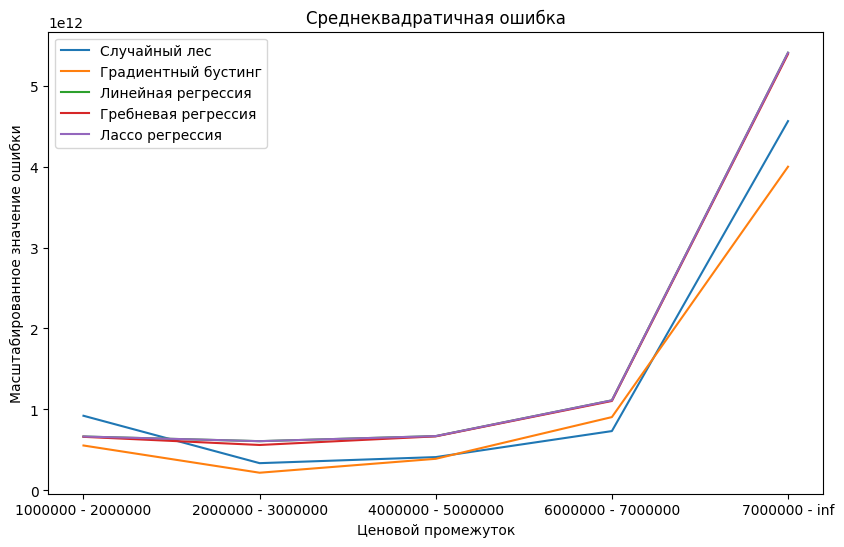

In [326]:
plt.figure(figsize=(10, 6))
plt.ylabel('Масштабированное значение ошибки')
plt.xlabel('Ценовой промежуток')
plt.title('Среднеквадратичная ошибка')

for elem in ['Случайный лес', 'Градиентный бустинг', 'Линейная регрессия', 'Гребневая регрессия', 'Лассо регрессия']:
    plt.plot(np.array(groups[:5]), df_mse[df_mae['Модель'] == elem]['Ошибка'], label=elem)
plt.legend()

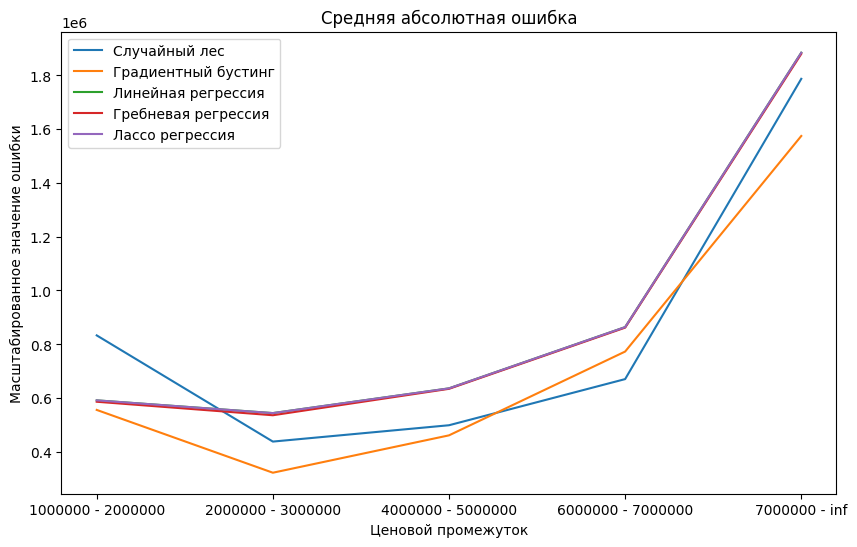

In [327]:
plt.figure(figsize=(10, 6))
plt.ylabel('Масштабированное значение ошибки')
plt.xlabel('Ценовой промежуток')
plt.title('Средняя абсолютная ошибка')

for elem in ['Случайный лес', 'Градиентный бустинг', 'Линейная регрессия', 'Гребневая регрессия', 'Лассо регрессия']:
    plt.plot(np.array(groups[:5]), df_mae[df_mae['Модель'] == elem]['Ошибка'], label=elem)
plt.legend()

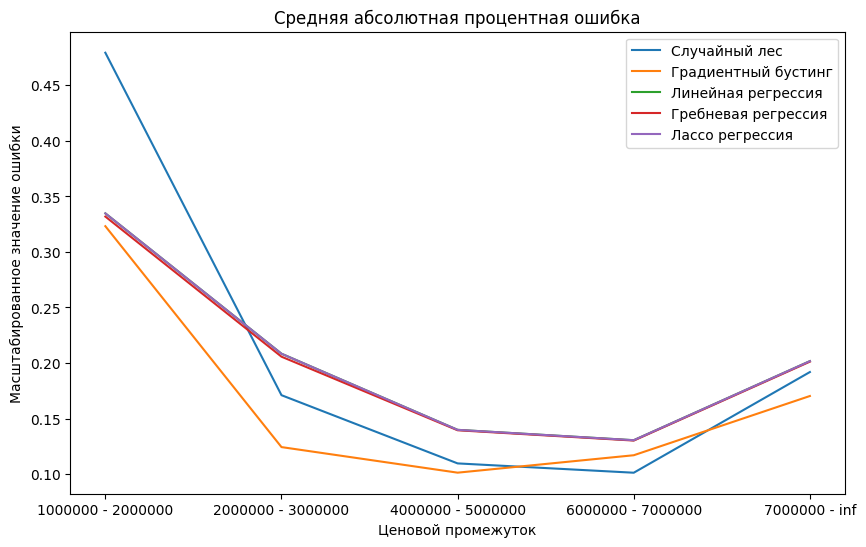

In [343]:
plt.figure(figsize=(10, 6))
plt.ylabel('Масштабированное значение ошибки')
plt.xlabel('Ценовой промежуток')
plt.title('Средняя абсолютная процентная ошибка')

for elem in ['Случайный лес', 'Градиентный бустинг', 'Линейная регрессия', 'Гребневая регрессия', 'Лассо регрессия']:
    plt.plot(np.array(groups[:5]), df_mape[df_mae['Модель'] == elem]['Ошибка'], label=elem)
plt.legend()